# Modelo de predição de falência de bancos
Neste notebook, iremos tentar prever o maior número possíveis de bancos que podem falir num futuro próximo, utilizando uma base de dados reais do Jornal Econômico de Taiwan entre os anos de 1999 a 2009.

Meu objetivo aqui, além de aprender, será tentar prever com o recall mais alto o possível os bancos que podem ou não falir.

Um modelo assim é muito importante para bancos da vida real, ou para estudo de indices econômicos. Como por exemplo, bancos que emprestam crédito ou realizam empréstimos a outros bancos, ou seja, negócios B2B. Pois, emprestar dinheiro a bancos não confiáveis significa um prejuízo futuro muito grande e substancial.

 # **Importando o Pandas**

In [28]:
import pandas as pd

# Carregando o Dataset

In [29]:
dataset = pd.read_csv('data.csv')

# Mostrando o Dataset

Checango as primeiras linhas do Dataset

In [30]:
print(dataset.head(10)) # Checar o head

   Bankrupt?   ROA(C) before interest and depreciation before interest  \
0          1                                           0.370594          
1          1                                           0.464291          
2          1                                           0.426071          
3          1                                           0.399844          
4          1                                           0.465022          
5          1                                           0.388680          
6          0                                           0.390923          
7          0                                           0.508361          
8          0                                           0.488519          
9          0                                           0.495686          

    ROA(A) before interest and % after tax  \
0                                 0.424389   
1                                 0.538214   
2                                 0.499019   
3

# Verificando a proporção de cada classe para checar desbalanceamentos

In [31]:
print(dataset['Bankrupt?'].value_counts(normalize=True)*100)

Bankrupt?
0    96.77372
1     3.22628
Name: proportion, dtype: float64


Aqui ele mostra que há uma proporção bem desigual, o que obviamente é explicado por que são dados reais, com 96% de bancos que não tem chances de ir a falência.
Um dataset tão desbalanceado com certeza terá problemas com o treinamento, com altas chances de viés, por isso, optei por utilizar algumas técnicas de balanceamento a fim de melhorar a forma como o modelo pode generalizar.

# Verificando valores ausentes

In [32]:
print(dataset.isnull().sum())

Bankrupt?                                                   0
 ROA(C) before interest and depreciation before interest    0
 ROA(A) before interest and % after tax                     0
 ROA(B) before interest and depreciation after tax          0
 Operating Gross Margin                                     0
                                                           ..
 Liability to Equity                                        0
 Degree of Financial Leverage (DFL)                         0
 Interest Coverage Ratio (Interest expense to EBIT)         0
 Net Income Flag                                            0
 Equity to Liability                                        0
Length: 96, dtype: int64


**Renomeando as features**

Aqui as features serão renomeadas para um melhor entendimento.

In [33]:
columns = ['Y'] + [f"X{i+1}" for i in range(dataset.shape[1] - 1)]
dataset.columns = columns

In [34]:
print(dataset.head(10))

   Y        X1        X2        X3        X4        X5        X6        X7  \
0  1  0.370594  0.424389  0.405750  0.601457  0.601457  0.998969  0.796887   
1  1  0.464291  0.538214  0.516730  0.610235  0.610235  0.998946  0.797380   
2  1  0.426071  0.499019  0.472295  0.601450  0.601364  0.998857  0.796403   
3  1  0.399844  0.451265  0.457733  0.583541  0.583541  0.998700  0.796967   
4  1  0.465022  0.538432  0.522298  0.598783  0.598783  0.998973  0.797366   
5  1  0.388680  0.415177  0.419134  0.590171  0.590251  0.998758  0.796903   
6  0  0.390923  0.445704  0.436158  0.619950  0.619950  0.998993  0.797012   
7  0  0.508361  0.570922  0.559077  0.601738  0.601717  0.999009  0.797449   
8  0  0.488519  0.545137  0.543284  0.603612  0.603612  0.998961  0.797414   
9  0  0.495686  0.550916  0.542963  0.599209  0.599209  0.999001  0.797404   

         X8        X9  ...       X86       X87       X88       X89       X90  \
0  0.808809  0.302646  ...  0.716845  0.009219  0.622879  0.6

# Correlação entre as features do dataset sem tratamento

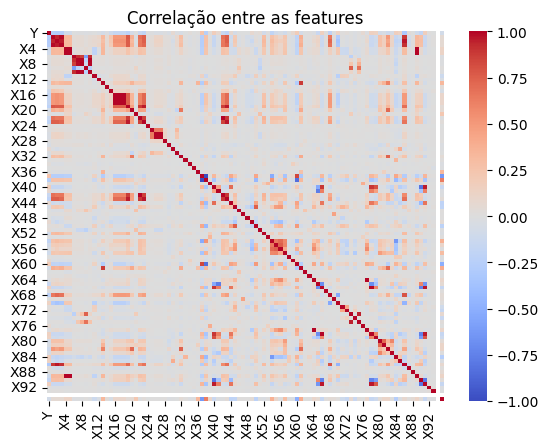

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = dataset.corr()
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title("Correlação entre as features")
plt.show()

**Features mais positivamente correlacionadas com o target**

Para melhorar o recall do modelo, decidi escolher as 10 melhores features que são relacionadas com o nosso target (Falência ou não falência), ou seja, as features que estiverem mais relacionadas com ele, serão utilizadas para treinar o modelo.

In [36]:
correlation = dataset.corr()['Y'].sort_values(ascending=False)

In [37]:
positive_correlation = correlation[correlation > 0].sort_values(ascending=False).head(15)
negative_correlation = correlation[correlation < 0].head(15)

In [38]:
print("Features positivamente correlacionadas com Y:")
print(positive_correlation)

print("\nFeatures negativamente correlacionadas com Y:")
print(negative_correlation)

Features positivamente correlacionadas com Y:
Y      1.000000
X37    0.250161
X60    0.194494
X40    0.176543
X84    0.171306
X91    0.166812
X66    0.153828
X78    0.153828
X85    0.139212
X70    0.139049
X79    0.139014
X59    0.077921
X44    0.075278
X49    0.072818
X41    0.070455
Name: Y, dtype: float64

Features negativamente correlacionadas com Y:
X6    -0.000230
X24   -0.000458
X48   -0.001376
X62   -0.001906
X33   -0.002211
X35   -0.002681
X73   -0.002894
X58   -0.003823
X21   -0.004692
X46   -0.004754
X93   -0.005509
X88   -0.005547
X11   -0.006083
X47   -0.006556
X69   -0.007137
Name: Y, dtype: float64


**Dividindo o banco em treino e teste**

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
X, y = dataset.drop('Y', axis=1), dataset['Y']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, shuffle=True, stratify=y, random_state=42)

**Verificando correlação entre as features no dataset de treino**

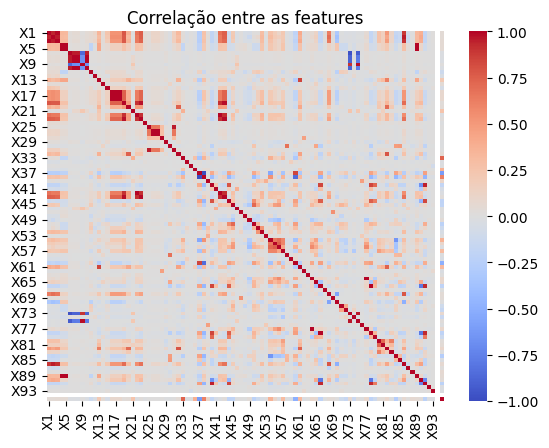

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = X_train.corr()
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title("Correlação entre as features")
plt.show()

In [43]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4568, 95) (2251, 95) (4568,) (2251,)


# Verificando a contagem de targets no conjunto de treinamento

In [44]:
contagem_bakrupt = y_train.value_counts()

In [45]:
print("Contagem de classes no conjunto de treinamento:")
print(contagem_bakrupt)

Contagem de classes no conjunto de treinamento:
Y
0    4421
1     147
Name: count, dtype: int64


In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

<ipython-input-47-cec5e51b0db9>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=contagem_bakrupt.index, y=contagem_bakrupt.values, palette='viridis')


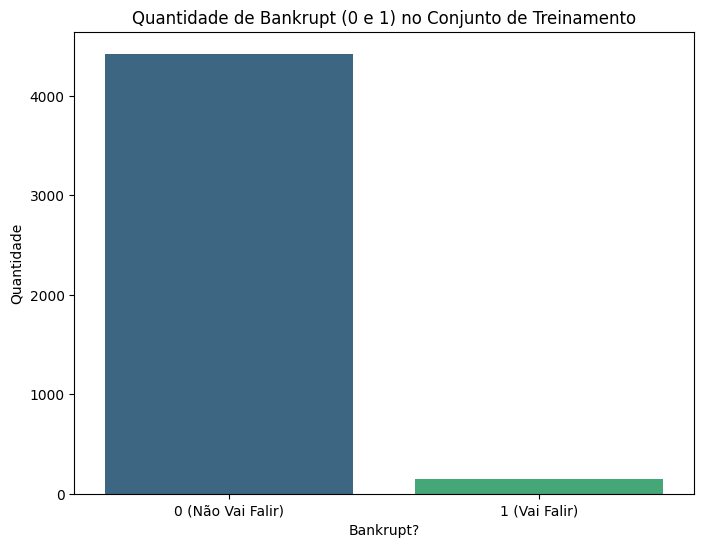

In [47]:
plt.figure(figsize=(8, 6))
sns.barplot(x=contagem_bakrupt.index, y=contagem_bakrupt.values, palette='viridis')
plt.title('Quantidade de Bankrupt (0 e 1) no Conjunto de Treinamento')
plt.xlabel('Bankrupt?')
plt.ylabel('Quantidade')
plt.xticks(ticks=[0, 1], labels=['0 (Não Vai Falir)', '1 (Vai Falir)'])
plt.show()

# **Realizando o balanceamento dos dados no conjunto de treino**

Aqui, utilizei uma pipeline unindo SMOTE com TomekLinks para balancear os dados no conjunto de treino

In [48]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline
import numpy as np

In [49]:
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('tomek', TomekLinks())
])

In [50]:
X_train_balanced, y_train_balanced = pipeline.fit_resample(X_train, y_train)

# Contando as classes no conjunto de treino balanceado

In [51]:
print("Novas contagens de classes:", y_train_balanced.value_counts())

Novas contagens de classes: Y
0    4421
1    4395
Name: count, dtype: int64


# **Selecionando as 10 melhores features**

In [52]:
top_10_features = ['X37', 'X60', 'X40', 'X84', 'X91', 'X66', 'X78', 'X85', 'X70']

In [53]:
X_train_top_10 = X_train_balanced[top_10_features]
X_test_top_10 = X_test[top_10_features]

# **Treinando o modelo**

O modelo escolhido foi o CatBoost. Nele constatei um recall muito bom para a classe 1, a custo de que o recall da classe 0 caísse um pouco, porém, foi o ponto de equilíbrio encontrado que mais me agradou



In [ ]:
!pip install catboost

from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from catboost import CatBoostClassifier

In [55]:
cat_model = CatBoostClassifier(
    iterations=1000,           # Número das Árvores
    learning_rate=0.05,        # Taxa de aprendizado
    depth=6,                  # Profundidade das árvores
    random_seed=42,           # Reprodutibilidade
    verbose=100,              # Mostra progresso durante o treino
    eval_metric="AUC",
    early_stopping_rounds=50,
)

# **Cross Val no conjunto balanceado de treino**

Cross Validation no conjunto de treino balanceado

In [56]:
cat_scores = cross_val_score(cat_model, X_train_balanced, y_train_balanced, cv=10, scoring='recall')

0:	total: 79.3ms	remaining: 1m 19s
100:	total: 4.83s	remaining: 43s
200:	total: 12.4s	remaining: 49.4s
300:	total: 18.7s	remaining: 43.5s
400:	total: 26.4s	remaining: 39.4s
500:	total: 31.9s	remaining: 31.8s
600:	total: 34.6s	remaining: 23s
700:	total: 38.8s	remaining: 16.6s
800:	total: 41.4s	remaining: 10.3s
900:	total: 43.9s	remaining: 4.82s
999:	total: 46.4s	remaining: 0us
0:	total: 34.6ms	remaining: 34.6s
100:	total: 3.79s	remaining: 33.7s
200:	total: 6.99s	remaining: 27.8s
300:	total: 9.6s	remaining: 22.3s
400:	total: 12.2s	remaining: 18.2s
500:	total: 14.8s	remaining: 14.7s
600:	total: 19.1s	remaining: 12.7s
700:	total: 21.7s	remaining: 9.24s
800:	total: 24.2s	remaining: 6.02s
900:	total: 26.8s	remaining: 2.94s
999:	total: 30.1s	remaining: 0us
0:	total: 63.7ms	remaining: 1m 3s
100:	total: 3.44s	remaining: 30.6s
200:	total: 6.05s	remaining: 24.1s
300:	total: 8.67s	remaining: 20.1s
400:	total: 11.3s	remaining: 16.8s
500:	total: 15.6s	remaining: 15.5s
600:	total: 18.1s	remaining: 12

In [57]:
print(f"CatBoost Recall Média: {cat_scores.mean():.3f}")

CatBoost Recall Média: 0.999


# **Treino dos modelos**

In [58]:
cat_model.fit(X_train_top_10, y_train_balanced, verbose=100, eval_set=(X_test_top_10, y_test), early_stopping_rounds=50)

0:	test: 0.8608815	best: 0.8608815 (0)	total: 6.63ms	remaining: 6.62s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9039775086
bestIteration = 48

Shrink model to first 49 iterations.


# **Previsões nos conjuntos de teste**

In [59]:
# Previsões no conjunto de teste
cat_preds = (cat_model.predict_proba(X_test_top_10)[:, 1] > 0.3).astype(int)

# Avaliação do Catboost

In [60]:
from sklearn.metrics import confusion_matrix

Classification Report - CatBoost
              precision    recall  f1-score   support

           0       0.99      0.78      0.88      2178
           1       0.12      0.88      0.21        73

    accuracy                           0.78      2251
   macro avg       0.56      0.83      0.54      2251
weighted avg       0.97      0.78      0.85      2251



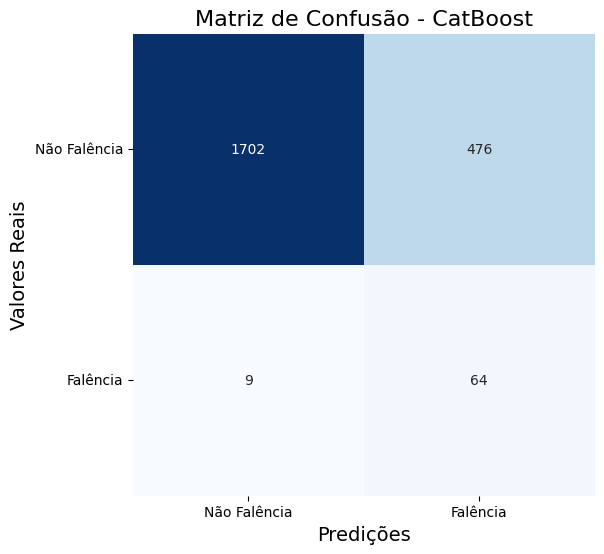

In [61]:
# Avaliação do modelo
print("Classification Report - CatBoost")
print(classification_report(y_test, cat_preds))

# Matriz de Confusão Visual
cm = confusion_matrix(y_test, cat_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
plt.title("Matriz de Confusão - CatBoost", fontsize=16)
plt.xlabel("Predições", fontsize=14)
plt.ylabel("Valores Reais", fontsize=14)
plt.xticks(ticks=[0.5, 1.5], labels=["Não Falência", "Falência"])
plt.yticks(ticks=[0.5, 1.5], labels=["Não Falência", "Falência"], rotation=0)
plt.show()

# Gráfico ROC AUC

In [62]:
from sklearn.metrics import roc_auc_score, roc_curve

In [63]:
fpr, tpr, thresholds = roc_curve(y_test, cat_preds)
roc_auc = roc_auc_score(y_test, cat_preds)

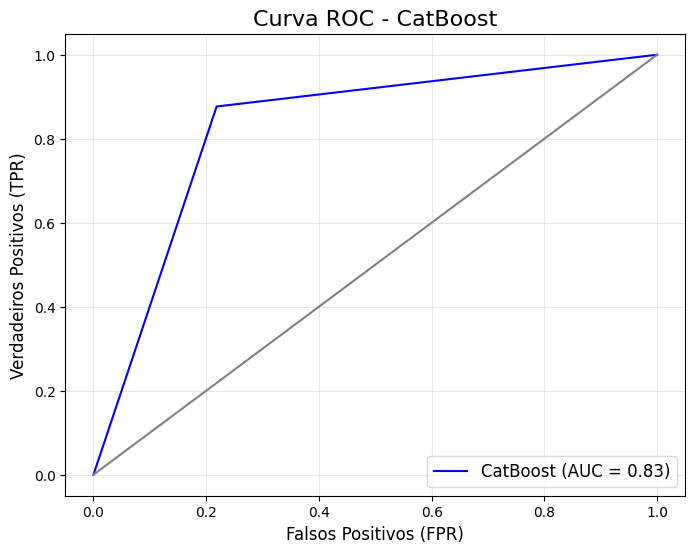

In [64]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"CatBoost (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="-")  # Linha diagonal
plt.xlabel("Falsos Positivos (FPR)", fontsize=12)
plt.ylabel("Verdadeiros Positivos (TPR)", fontsize=12)
plt.title("Curva ROC - CatBoost", fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Considerações finais

Nesta matriz de confusão, observamos o desempenho do modelo CatBoost, que foi comparado com outros modelos, como Random Forest, XGBoost e HistGradientBoostingClassifier. Embora esses modelos tenham apresentado resultados promissores, o CatBoost demonstrou o melhor recall para a classe 1, que representa bancos em risco de falência.

O aumento no recall da classe 1 foi alcançado à custa de uma redução significativa no recall da classe 0. Em termos práticos, isso implica que o modelo é mais eficaz em identificar bancos que estão em risco de falência (reduzindo o risco de prejuízos financeiros), mas também apresenta um número elevado de falsos positivos, ou seja, bancos saudáveis sendo classificados como em risco.

Para um banco de crédito, a adoção deste modelo exigiria uma análise cuidadosa dos custos e benefícios associados aos falsos positivos e negativos:

- Falsos Positivos (476 casos): Implicam em oportunidades perdidas, já que bancos saudáveis podem ser injustamente negados crédito.

- Falsos Negativos (9 casos): Representam um risco mais crítico, já que falhas em identificar bancos realmente em risco podem resultar em perdas financeiras significativas.

Apesar do trade-off, o modelo oferece uma alta confiabilidade na identificação de bancos em risco de falência (classe 1), tornando-o uma ferramenta valiosa em estratégias de mitigação de risco.

Para maximizar sua aplicabilidade, recomenda-se uma análise adicional para ajustar o threshold ou integrar o modelo a um processo de revisão manual para os casos classificados como "em risco".

# Exportando o modelo

In [65]:
from pickle import dump

In [66]:
filename = 'bankrupt_predict_model.pkl'

In [67]:
with open(filename, 'wb') as file:
    dump(cat_model, file)

In [68]:
print(f"Modelo salvo! Nome do arquivo:{filename}")

Modelo salvo! Nome do arquivo:bankrupt_predict_model.pkl
